Creating RawArray with float64 data, n_channels=14, n_times=2262
    Range : 0 ... 2261 =      0.000 ...     8.832 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Fitting ICA took 0.7s.
Creating RawArray with float64 data, n_channels=14, n_times=2262
    Range : 0 ... 2261 =      0.000 ...     8.832 secs
Ready.


/home/nakalab_2023/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Using matplotlib as 2D backend.


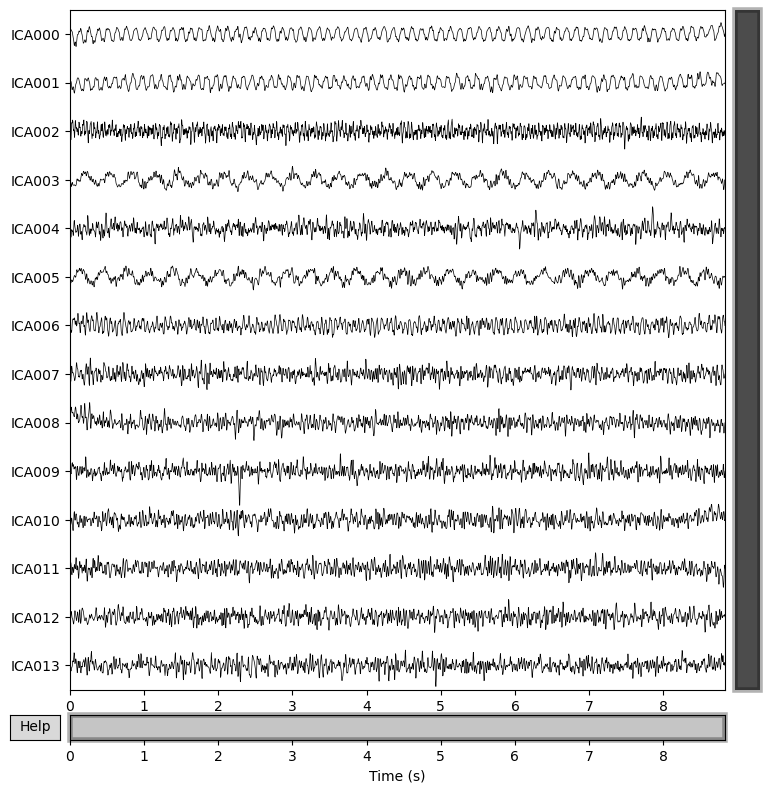

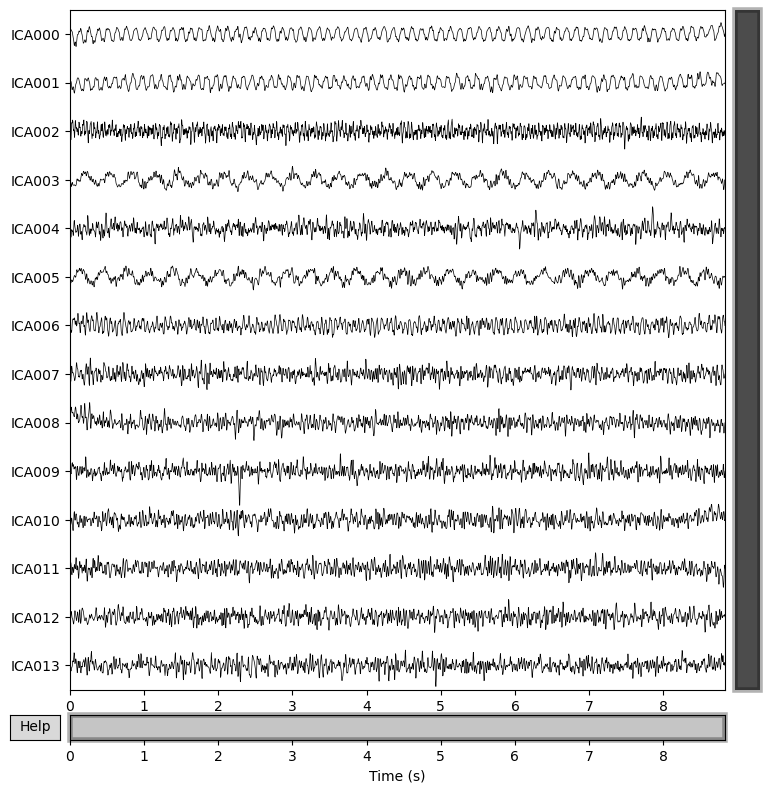

In [1]:
import csv
import numpy as np
import mne
from mne.preprocessing import ICA
from datetime import datetime

def load_data_from_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

def create_mne_raw_object(data, ch_names, sfreq):
    n_channels = len(ch_names)
    n_samples = len(data)

    data_array = np.empty((n_channels, n_samples))
    for i, row in enumerate(data):
        for j, ch_name in enumerate(ch_names):
            data_array[j, i] = float(row[ch_name])

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(data_array, info)
    return raw

filename = 'epoc_X_data.csv'
data = load_data_from_csv(filename)

# 選択したチャンネルをプロット
ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
sfreq =  128 # サンプリング周波数

raw = create_mne_raw_object(data, ch_names, sfreq)

# 事前にハイパスフィルタを適用してデータのトレンドを除去
raw.filter(l_freq=1, h_freq=None)

# ICAを実行
ica = ICA(n_components=14, random_state=97)
ica.fit(raw)

# ICA成分をプロット
ica.plot_sources(raw)

In [ ]:
#EOG除去を試すためのもの

import csv
import numpy as np
import mne
from mne.preprocessing import ICA
from datetime import datetime

def load_data_from_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

def create_mne_raw_object(data, ch_names, sfreq):
    n_channels = len(ch_names)
    n_samples = len(data)

    data_array = np.empty((n_channels, n_samples))
    for i, row in enumerate(data):
        for j, ch_name in enumerate(ch_names):
            data_array[j, i] = float(row[ch_name])

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(data_array, info)
    return raw

filename = 'epoc_X_data_ICAtest.csv'
data = load_data_from_csv(filename)

# 選択したチャンネルをプロット
ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
sfreq =  128 # サンプリング周波数

raw = create_mne_raw_object(data, ch_names, sfreq)

# 事前にハイパスフィルタを適用してデータのトレンドを除去
raw.filter(l_freq=1, h_freq=None)

# ICAを実行
ica = ICA(n_components=14, random_state=97)
ica.fit(raw)

# ICA成分をプロット
ica.plot_sources(raw)

In [2]:
#手動によるEOG(眼球運動)除去のためのもの

# ICA成分をプロット
ica.plot_components()

# 眼球運動に関連する成分のインデックスを追加
EOG_index = 0 #EOGだと思われるインデクス番号（データによって異なる）
ica.exclude = [EOG_index] 

# ICA を適用してノイズを除去
raw_clean = raw.copy()
ica.apply(raw_clean)

In [ ]:
#アーティファクト検出アルゴリズムを使用したもの

import numpy as np
from mne.preprocessing import compute_corr_matrix

# ICA 成分と他のチャンネルとの相関を計算
corr_matrix = compute_corr_matrix(ica.get_sources(raw).get_data(), raw.get_data())

# 閾値以上の相関がある成分を特定
threshold = 0.8　#なんとなく0.8
bad_indices = np.where(np.abs(corr_matrix) > threshold)

# 眼球運動に関連する成分のインデックスを追加
ica.exclude = np.unique(bad_indices[0])

# ICA を適用してノイズを除去
raw_clean = raw.copy()
ica.apply(raw_clean)